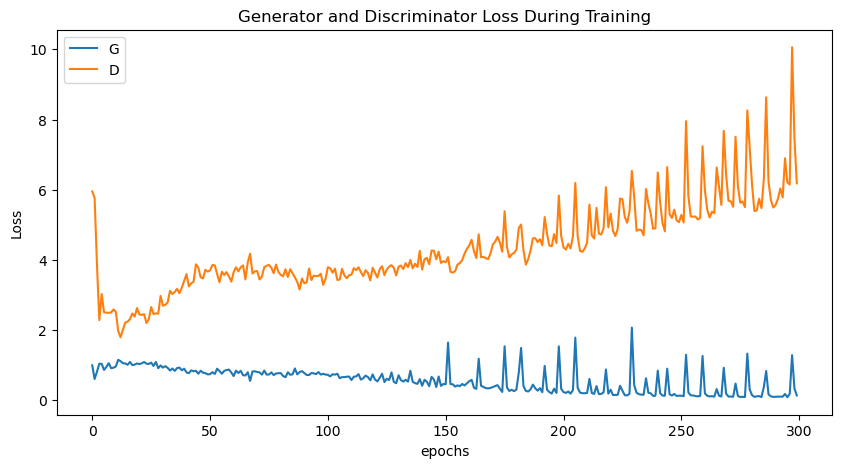

In [97]:
torch.save({
            'generator' : netG.state_dict(),
            'discriminator' : netD.state_dict(),
            'optimizerG' : optimizerG.state_dict(),
            'optimizerD' : optimizerD.state_dict(),
            'params' : params
            }, 'model_animals_final.pth')

# Plot the training losses.
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


![alt text](image-2.png)

In [104]:
params = {
    'dim_z' : 100,
    'num_epochs' : 300,
    'lr' : 0.0002,
    'save_epoch' : 10,
    'k_d':1,
    'k_g':1}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
netG = Generator(params).to(device)
netD = Discriminator().to(device)

# Load the model checkpoint
checkpoint = torch.load('model_animals_epoch_180.pth', map_location=device)

netG.load_state_dict(checkpoint['generator'])
netD.load_state_dict(checkpoint['discriminator'])

netG = netG.to(device)
netD = netD.to(device)

netG.eval()
fid_value = calculate_fid_animals(netG,params)
print(f"FID Score : {fid_value}")


100%|██████████| 17/17 [00:02<00:00,  5.83it/s]


FID Score : 148.74984419654055


FID Score : 148.74984419654055

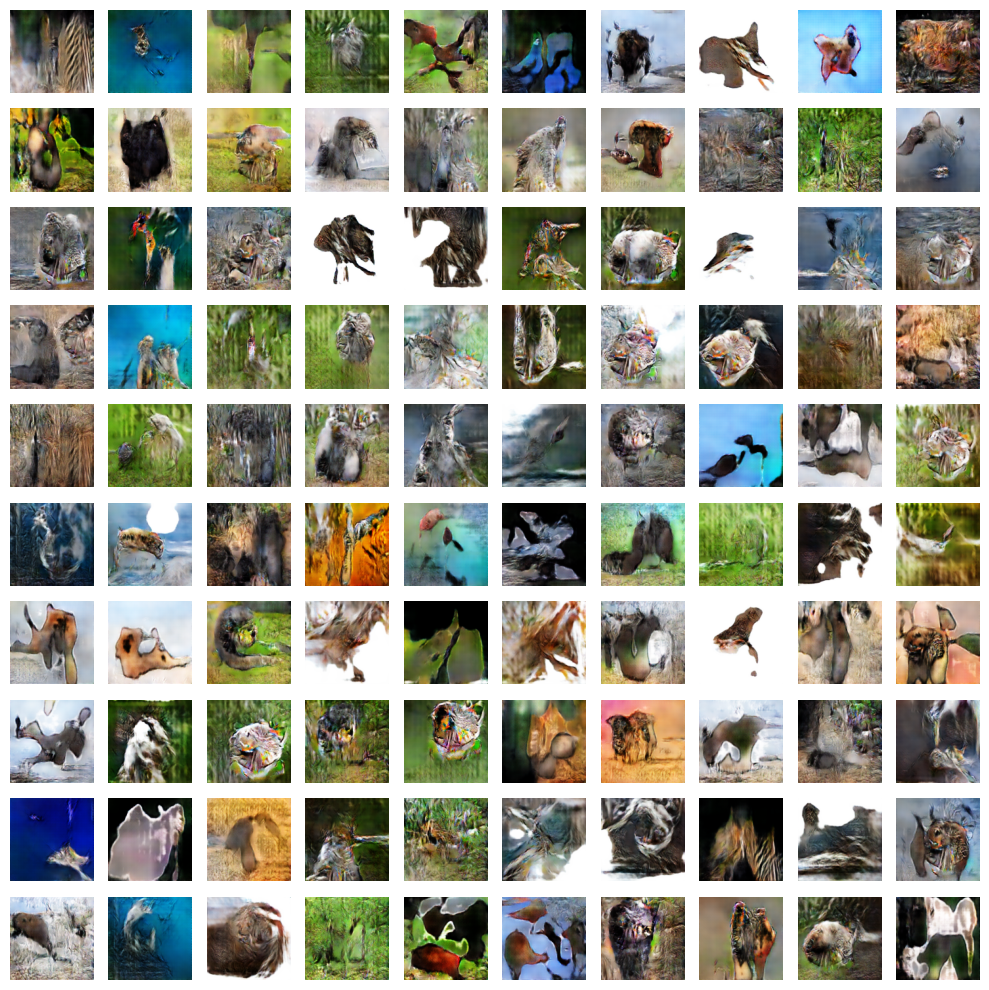

In [110]:
z = torch.randn(100, params['dim_z'], 1, 1, device=device)
with torch.no_grad():
    generated_img = netG(z).detach().cpu()

fig, axs = plt.subplots(10, 10, figsize=(10, 10))

for i in range(10):
    for j in range(10):
        img = generated_img[i * 10 + j].permute(1, 2, 0).detach().numpy()
        min_val = img.min()
        max_val = img.max()
        normalized_img = (img - min_val) / (max_val - min_val)
                
        # Plot the image
        axs[i, j].imshow(normalized_img)
        axs[i, j].axis('off')


plt.tight_layout()
plt.show()

#### Generated Images

![alt text](image-3.png)

## Latent Space Traversal

In [120]:
params = {
    'dim_z' : 100,
    'num_epochs' : 500,
    'lr' : 0.0002,
    'save_epoch' : 10,
    'k_d':2,
    'k_g':1}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
netG = Generator(params).to(device)
netD = Discriminator().to(device)

# Load the model checkpoint
checkpoint = torch.load('model_butterfly_epoch_300.pth', map_location=device)

netG.load_state_dict(checkpoint['generator'])
netD.load_state_dict(checkpoint['discriminator'])

netG = netG.to(device)
netD = netD.to(device)

netG.eval()
netD.eval()


Discriminator(
  (conv1): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(1024, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (linear1): Sequential(
    (0): Linear(in_features=25, out_features=1, bias=True)
    (1): Sigmoid()
  )
)

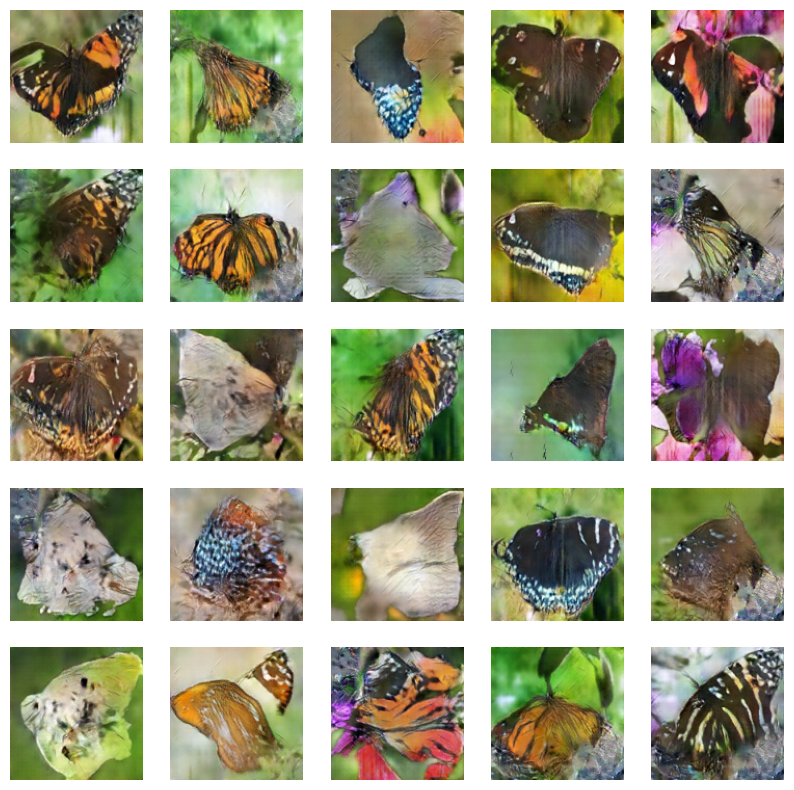

In [121]:

num_points = 25  
nz = params['dim_z']  
random_points = torch.randn(num_points, nz, 1, 1, device=device)


with torch.no_grad():
    generated_images = netG(random_points)



# Plot the 25 generated images in a 5x5 grid
fig, axs = plt.subplots(5, 5, figsize=(10, 10))

for i, ax in enumerate(axs.flatten()):
    img = generated_images[i].cpu().numpy().transpose(1, 2, 0) 
    min_val = img.min()
    max_val = img.max()
    normalized_img = (img - min_val) / (max_val - min_val)
    ax.imshow(normalized_img)
    ax.axis('off')  

plt.show()


In [122]:
# Linear Interpolation
def interpolate_vectors(v1, v2, steps=10):
    v1_flat = v1.view(-1)
    v2_flat = v2.view(-1) 

    alpha_values = np.linspace(0, 1, steps)
    interpolated = [(1 - alpha) * v1_flat + alpha * v2_flat for alpha in alpha_values]

    interpolated = [v.view(v1.shape) for v in interpolated]
    return torch.stack(interpolated)

# Spherical interpolation (Slerp)
def slerp(v1, v2, t):
    v1_norm = v1 / torch.norm(v1)
    v2_norm = v2 / torch.norm(v2)
    dot_product = torch.dot(v1_norm.view(-1), v2_norm.view(-1))
    dot_product = torch.clamp(dot_product, -1, 1)  

    theta = torch.acos(dot_product)

    sin_theta = torch.sin(theta)
    if sin_theta == 0:  
        return (1 - t) * v1 + t * v2
    
    return (torch.sin((1 - t) * theta) / sin_theta) * v1 + (torch.sin(t * theta) / sin_theta) * v2

def interpolate_slerp(v1, v2, steps=10):
    t_values = np.linspace(0, 1, steps)
    interpolated = [slerp(v1, v2, t) for t in t_values]
    return torch.stack(interpolated)

# Quadratic Bezier interpolation 
def interpolate_bezier(v1, v2, steps=10):
    v1_flat = v1.view(-1)
    v2_flat = v2.view(-1) 
    v0 = torch.randn_like(v1_flat).to(v1.device)

    t_values = np.linspace(0, 1, steps)
    interpolated = []
    
    for t in t_values:
        # Bezier interpolation formula (quadratic)
        bezier_vector = (1 - t)**2 * v1_flat + 2 * (1 - t) * t * v0 + t**2 * v2_flat
        interpolated.append(bezier_vector)
    interpolated = [v.view(v1.shape) for v in interpolated]

    return torch.stack(interpolated)



#### Interpolating between a random point and a point at a fixed distance from this random point

Linear Interpolation 